In [191]:
#importing libraries
import os
import re
import nltk

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aysukaymak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aysukaymak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aysukaymak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Overview of data

In [192]:
#function for reading csv tables into dataframes
def read_csv_files(path):
    file_list=os.listdir(path)
    dataframes=[]
    for file_name in file_list:
        file_path=os.path.join(path, file_name)
        
        if file_name.endswith('.csv'):
            df=pd.read_csv(file_path)
            df.drop(columns=["url", "content"],inplace=True)
            dataframes.append(df)
        elif file_name.endswith('.json'):
            df = pd.read_json(file_path, lines=True)  # Read JSONL files
            df.drop(columns=['authors', 'link', 'date'], inplace=True, errors='ignore')
            df.rename(columns = {'headline':'headlines', 'short_description':'description'}, inplace = True)
            df.loc[:,['headlines','description','category']]
            dataframes.append(df)

    #shuffling the columns for the randomness and resetting index of df
    combined_df=shuffle(pd.concat(dataframes, ignore_index=True))
        
    return combined_df

In [193]:
path=r'data-topic-classification'
df=read_csv_files(path)

df.head()

category                                          headlines  \
192167          TRAVEL  Color In La Candelaria: A Look At Bogota's Liv...   
42166         POLITICS  White Nationalists Are Ecstatic About Jeff Ses...   
94063   HEALTHY LIVING  Preventing Murder-Suicides: How the Germanwing...   
94002          SCIENCE  Stunning New Time Lapse Video Shows The Sun Up...   
152028          TRAVEL  How Someone Who's Always Traveling Runs a Trav...   

                                              description  
192167  Although still a dangerous place to be wanderi...  
42166   Not a great look for Donald Trump's attorney g...  
94063   The Germanwings tragedy can further stigmatize...  
94002                                                      
152028  The ETBD Business Team: From left to right, Ri...

In [194]:
print(df.shape)

(219527, 3)


In [195]:
# information about metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219527 entries, 192167 to 11350
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   category     219527 non-null  object
 1   headlines    219527 non-null  object
 2   description  219527 non-null  object
dtypes: object(3)
memory usage: 6.7+ MB


In [196]:
# Print distinct values of the 'cat' feature
print("Distinct categories:", df['category'].unique())

df['category'] = df['category'].str.upper()
df['category'].replace('TECH', 'TECHNOLOGY', inplace=True)
print("Distinct categories:", df['category'].unique())


Distinct categories: ['TRAVEL' 'POLITICS' 'HEALTHY LIVING' 'SCIENCE' 'STYLE & BEAUTY' 'MEDIA'
 'TASTE' 'DIVORCE' 'FOOD & DRINK' 'BUSINESS' 'COMEDY' 'WORLD NEWS'
 'PARENTING' 'WEDDINGS' 'QUEER VOICES' 'ENTERTAINMENT' 'CRIME' 'WELLNESS'
 'ENVIRONMENT' 'entertainment' 'ARTS & CULTURE' 'sports' 'COLLEGE'
 'HOME & LIVING' 'GREEN' 'WEIRD NEWS' 'PARENTS' 'WOMEN' 'MONEY' 'business'
 'ARTS' 'TECH' 'SPORTS' 'THE WORLDPOST' 'BLACK VOICES' 'GOOD NEWS' 'STYLE'
 'RELIGION' 'WORLDPOST' 'education' 'IMPACT' 'technology' 'EDUCATION'
 'U.S. NEWS' 'FIFTY' 'LATINO VOICES' 'CULTURE & ARTS']
Distinct categories: ['TRAVEL' 'POLITICS' 'HEALTHY LIVING' 'SCIENCE' 'STYLE & BEAUTY' 'MEDIA'
 'TASTE' 'DIVORCE' 'FOOD & DRINK' 'BUSINESS' 'COMEDY' 'WORLD NEWS'
 'PARENTING' 'WEDDINGS' 'QUEER VOICES' 'ENTERTAINMENT' 'CRIME' 'WELLNESS'
 'ENVIRONMENT' 'ARTS & CULTURE' 'SPORTS' 'COLLEGE' 'HOME & LIVING' 'GREEN'
 'WEIRD NEWS' 'PARENTS' 'WOMEN' 'MONEY' 'ARTS' 'TECHNOLOGY'
 'THE WORLDPOST' 'BLACK VOICES' 'GOOD NEWS' 'STYLE' '

In [197]:
# Calculate the number of missing/distinct values and duplicate rows for each feature
print("Number of missing values\n", df.isnull().sum())
print("\nNumber of distinct values\n", df.nunique())
print("\nNumber of duplicates\n", df.duplicated().sum())

Number of missing values
 category       0
headlines      0
description    0
dtype: int64

Number of distinct values
 category           42
headlines      217983
description    197000
dtype: int64

Number of duplicates
 482


In [198]:
# Remove duplicates
df.drop_duplicates(subset=['headlines', 'description', 'category'], keep='first', inplace=True)
print("\nNumber of duplicates\n", df.duplicated().sum())


Number of duplicates
 0


In [199]:
df.describe()

category       headlines description
count     219045          219045      219045
unique        42          217983      197000
top     POLITICS  Sunday Roundup            
freq       35585              90       19619

## EDA

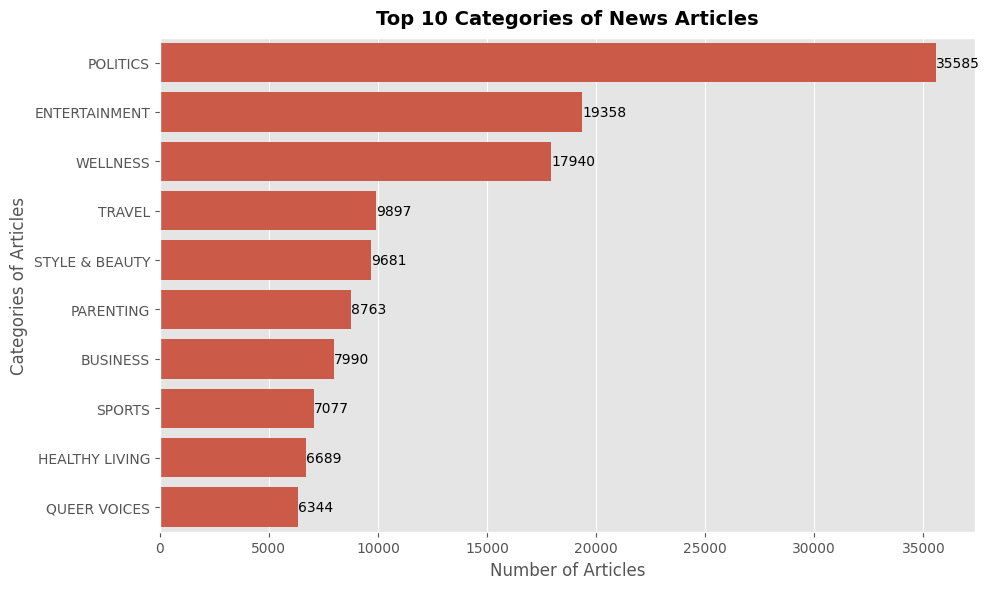

In [164]:
# Plotting the top 0 categories
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()

plt.figure(figsize=(10,6))
ax=sns.barplot(cat_df[:10], x="count", y="category", estimator="sum")
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Top 10 Categories of News Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Categories of Articles')
plt.savefig('outputs/top_10_categories_of_articles', bbox_inches='tight')
plt.show()


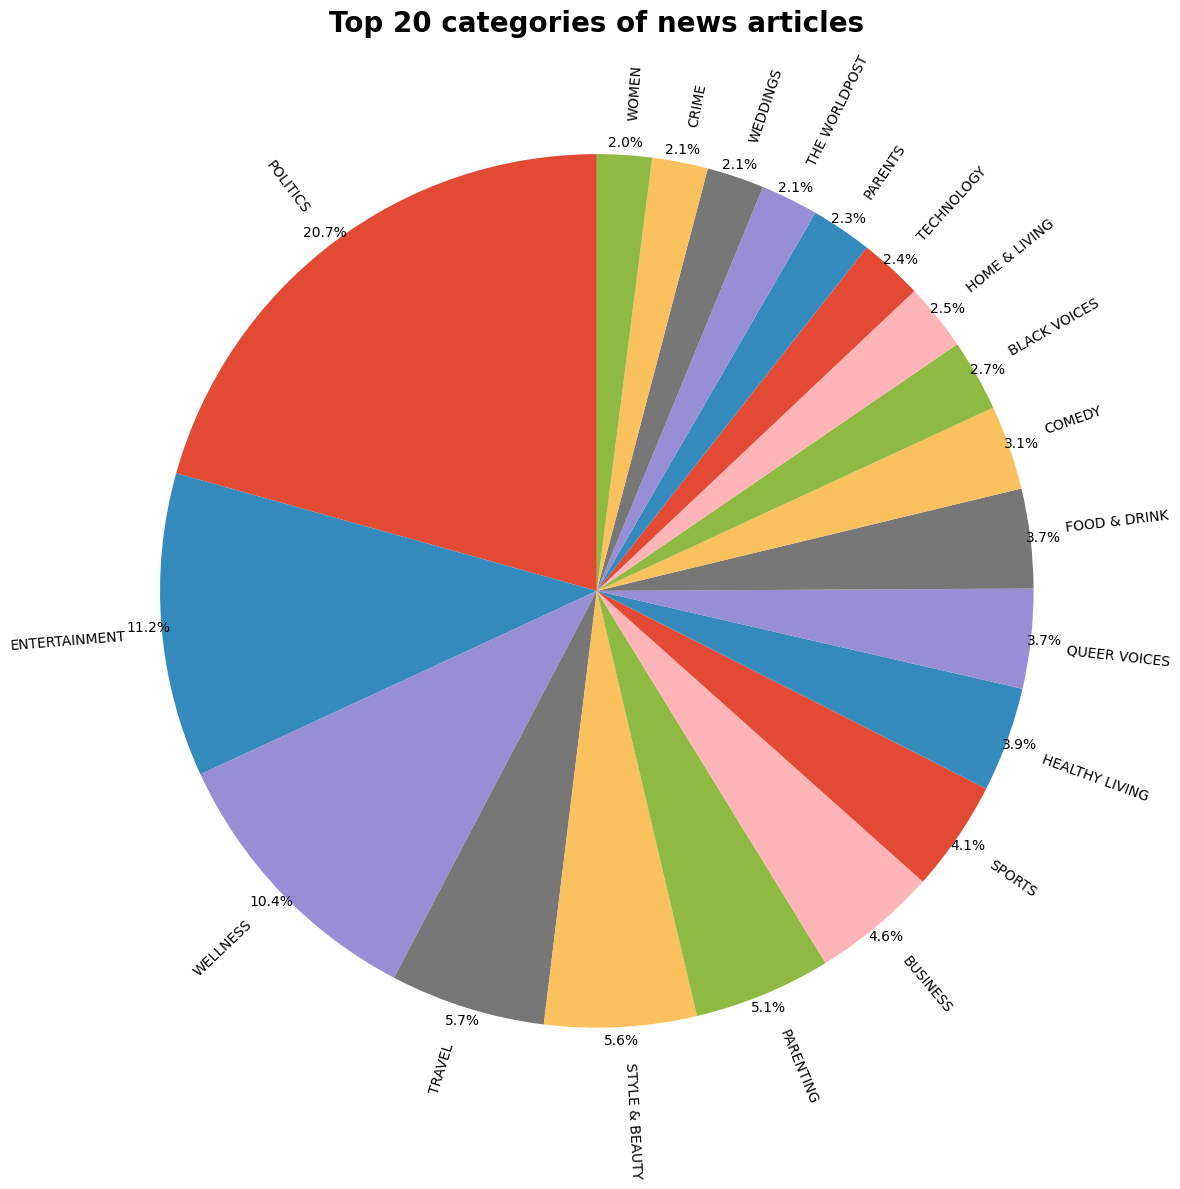

In [165]:
# Plotting the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['count'][:20],
            labels=cat_df['category'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Top 20 categories of news articles", size=20, weight='bold')
plt.savefig('outputs/top_20_categories_of_articles', bbox_inches='tight')
plt.show()

(-0.5, 1599.5, 599.5, -0.5)

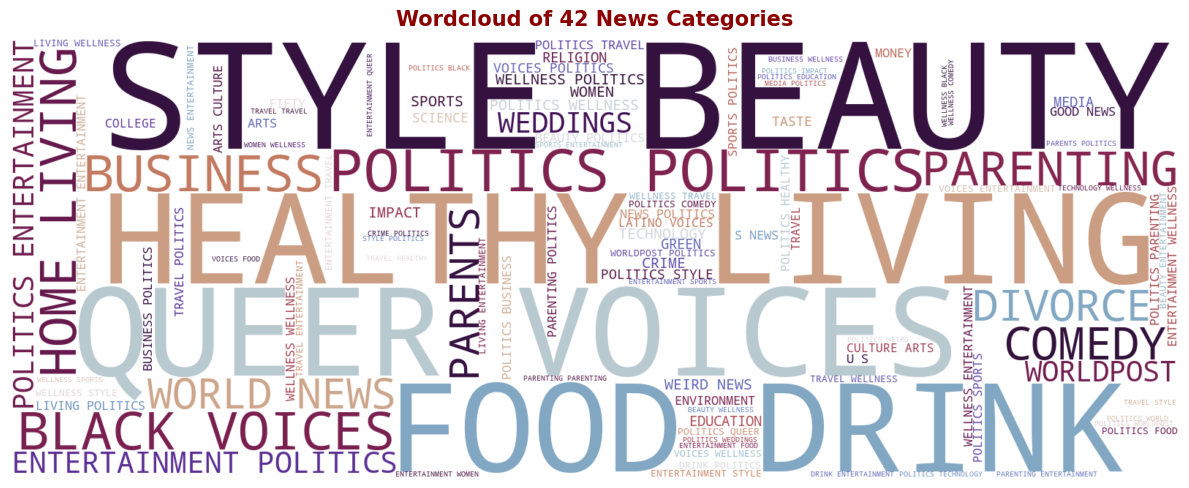

In [166]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='white',
               contour_color='white',
               colormap='twilight_r',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df.category))

plt.title("Wordcloud of 42 News Categories", size=15, weight='bold', color='darkred')
plt.imshow(wc, interpolation= "bilinear")
plt.savefig('outputs/wordcloud', bbox_inches='tight')
plt.axis('off')


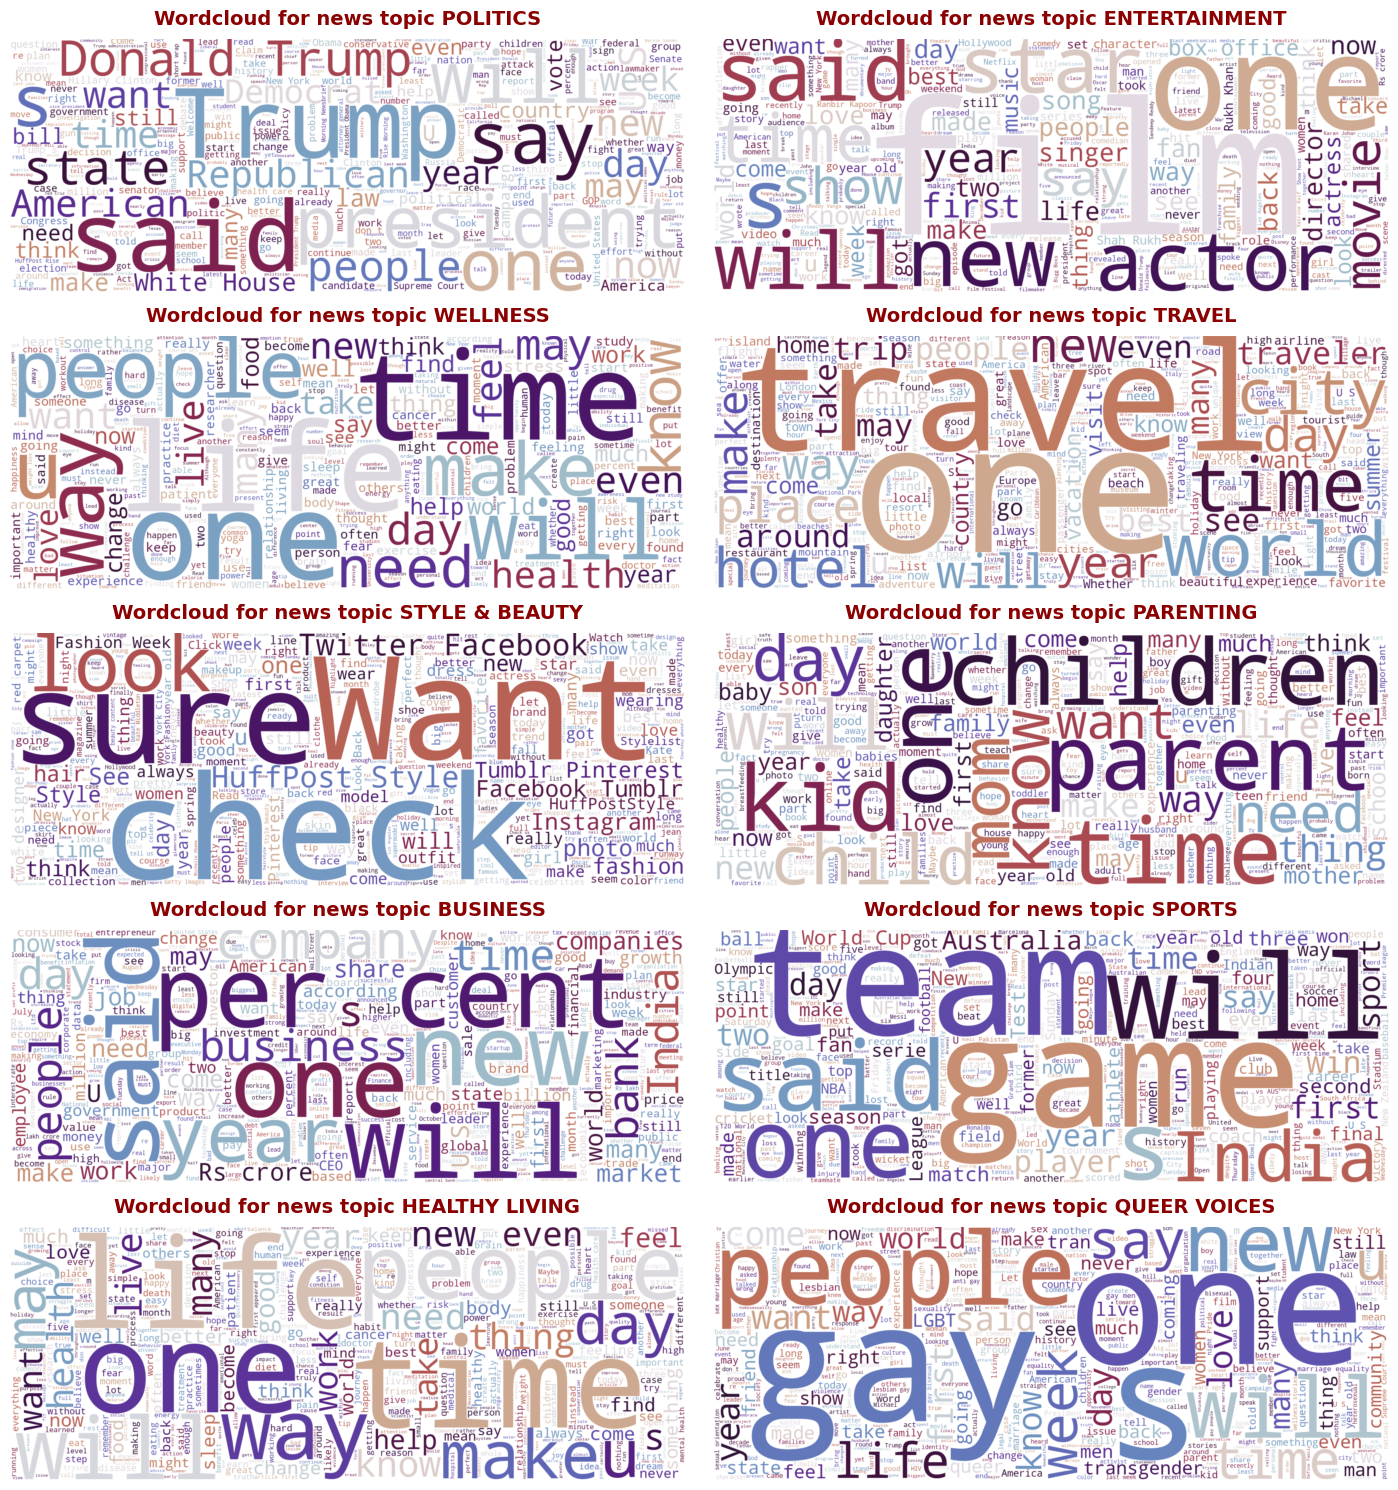

In [167]:
# list of top 10  categories in out dataset
categories = cat_df['category'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    catw_df = df[df['category'] == i]
    catw_array = catw_df['description'].values  # array of news articles text in each category
    articles_list.append(catw_array)
    
# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='white',
               contour_color='white',
               colormap='twilight_r',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}", weight='bold', color='darkred')
    plt.axis('off')

plt.savefig(f'outputs/wordclouds', bbox_inches='tight')

## Data Preprocessing

In [200]:
content_df=df.copy()
content_df.drop(columns=["headlines"],inplace=True)
content_df.head()

category                                        description
192167          TRAVEL  Although still a dangerous place to be wanderi...
42166         POLITICS  Not a great look for Donald Trump's attorney g...
94063   HEALTHY LIVING  The Germanwings tragedy can further stigmatize...
94002          SCIENCE                                                   
152028          TRAVEL  The ETBD Business Team: From left to right, Ri...

In [201]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)   

In [202]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",content_df['description'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(content_df['description'][0]))

Text sentence before pre-processing:
 She left her husband. He killed their children. Just another day in America.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 leave husband kill children another day america


In [203]:
# Applying datacleaning function to column 'length_of_news'
content_df['description'] = content_df['description'].apply(datacleaning)

In [204]:
# Length of total characters before and after cleaning text data
old_length = df['description'].apply(len).sum()
new_length = content_df['description'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 25468656
New chracters length of text data: 16362339


In [205]:
# Length of total words before and after cleaning text data
old_text = df['description'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = content_df['description'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 4376711
New word length of text data: 2399622


## Tokenization and Vectorization

In [206]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(content_df["description"][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words
            
max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1)) 

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 57)
Token index of unique words: 
 {'although': 1, 'still': 2, 'dangerous': 3, 'place': 4, 'wander': 5, 'around': 6, 'night': 7, 'la': 8, 'candelaria': 9, 'brim': 10, 'color': 11, 'personality': 12, 'intrigue': 13, 'great': 14, 'look': 15, 'donald': 16, 'trump': 17, 'attorney': 18, 'general': 19, 'pick': 20, 'germanwings': 21, 'tragedy': 22, 'stigmatize': 23, 'mental': 24, 'illness': 25, 'make': 26, 'people': 27, 'suicidal': 28, 'thoughts': 29, 'frighten': 30, 'theyll': 31, 'link': 32, 'horrific': 33, 'crime': 34, 'yet': 35, 'opportunity': 36, 'educate': 37, 'world': 38, 'warn': 39, 'sign': 40, 'suicide': 41, 'etbd': 42, 'business': 43, 'team': 44, 'leave': 45, 'right': 46, 'rich': 47, 'sorensen': 48, 'karen': 49, 'scholl': 50, 'brooke': 51, 'burdick': 52, 'mary': 53, 'romano': 54, 'anne': 55, 'kirchner': 56}


In [215]:
# one hot encoding using keras tokenizer and pad sequencing
X = content_df["description"]
encoder = LabelEncoder()
y = encoder.fit_transform(content_df['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=130) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=130)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130 # max length of sequence 
y_train = to_categorical(y_train, num_classes=42)
y_test = to_categorical(y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (219045,)
shape of target variable:  (219045,)
Length of word index: 77904


## Baseline Model Building using Embedding Layer and RNN

In [216]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 130, 70)           5453280   
                                                                 
 bidirectional_8 (Bidirecti  (None, 130, 128)          17280     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 130, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 42)               

In [217]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min')
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=1, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, 
                   batch_size=128, 
                    epochs=15, 
                    validation_split=0.2
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15


1096/1096 [==============================] - ETA: 0s - loss: 3.0944 - accuracy: 0.2149

InvalidArgumentError: Graph execution error:

Detected at node sequential_4/embedding_4/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\aysukaymak\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\aysukaymak\AppData\Local\Temp\ipykernel_8892\2295717766.py", line 14, in <module>

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1856, in fit

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\aysukaymak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[102,129] = 77904 is not in [0, 77904)
	 [[{{node sequential_4/embedding_4/embedding_lookup}}]] [Op:__inference_test_function_16061]